In [1]:
# DATASET LOADING AND PROCESSING (DO NEED TO MODIFY)
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam


def plot_airfoils(airfoil_x, airfoil_y):
    '''
    plot airfoils: no need to modify 
    '''
    idx = 0
    fig, ax = plt.subplots(nrows=4, ncols=4)
    for row in ax:
        for col in row:
            col.scatter(airfoil_x, airfoil_y[idx, :], s=0.6, c='black')
            col.axis('off')
            col.axis('equal')
            idx += 1
    plt.show()


class AirfoilDataset(Dataset):
    '''
    airfoil dataset: no need to modify
    '''
    def __init__(self, path='./airfoils'):
        super(AirfoilDataset, self).__init__()
        self._X = []	# x coordinates of all airfoils (shared)
        self._Y = []	# y coordinates of all airfoils
        self.names = []	# name of all airfoils
        self.norm_coeff = 0	# normalization coeff to scale y to [-1, 1]
        airfoil_fn = [afn for afn in os.listdir(path) if afn.endswith('.dat')]

        # get x coordinates of all airfoils
        with open(os.path.join(path, airfoil_fn[0]), 'r', encoding="utf8", errors='ignore') as f:
            raw_data = f.readlines()
            for idx in range(len(raw_data)):
                raw_xy = raw_data[idx].split(' ')
                while "" in raw_xy:
                    raw_xy.remove("")
                self._X.append(float(raw_xy[0]))
        self._X = np.array(self._X)

        # get y coordinates of each airfoils
        for idx, fn in enumerate(airfoil_fn):
            with open(os.path.join(path, fn), 'r', encoding="utf8", errors='ignore') as f:
                self.names.append(fn[:-10])
                raw_data = f.readlines()
                airfoil = np.empty(self._X.shape[0])
                for i in range(len(raw_data)):
                    raw_xy = raw_data[i].split(' ')
                    while "" in raw_xy:
                        raw_xy.remove("")
                    curr_y = float(raw_xy[1])
                    airfoil[i] = curr_y
                    self.norm_coeff = max(self.norm_coeff, np.abs(curr_y))
                self._Y.append(airfoil)

        self._Y = np.array([airfoil / self.norm_coeff for airfoil in self._Y], dtype=np.float32)

    def get_x(self):
        '''
        get shared x coordinates
        '''
        return self._X

    def get_y(self):
        '''
        get y coordinates of all airfoils
        '''
        return self._Y

    def __getitem__(self, idx):
        return self._Y[idx], self.names[idx]

    def __len__(self):
        return len(self._Y)

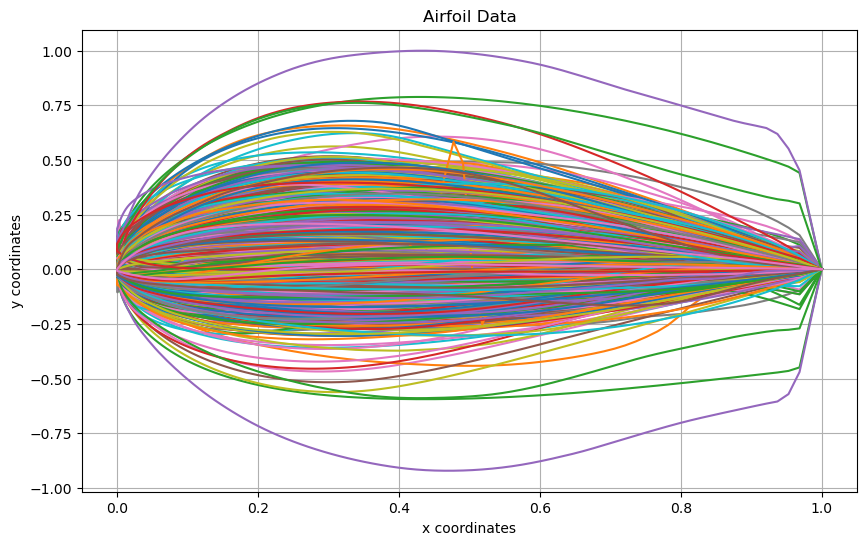

In [2]:
# Instantiate the dataset
dataset = AirfoilDataset()

# Get x coordinates
x_coords = dataset.get_x()

# Get y coordinates
y_coords = dataset.get_y()

# Visualize the data
plt.figure(figsize=(10, 6))
for i in range(len(y_coords)):
    plt.plot(x_coords, y_coords[i])

plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
plt.title('Airfoil Data')
plt.grid(True)
plt.show()


# VAE

In [3]:
from torch.nn import functional as F
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        # build your model here
        # your model should output a predicted mean and a predicted std of the encoding
        # both should be of dim (batch_size, latent_dim)
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2_mean = nn.Linear(128, latent_dim)
        self.fc2_logvar = nn.Linear(128, latent_dim)
    
    def forward(self, x):
        # define your feedforward pass
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, output_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        
    
    def forward(self, x):
        # define your feedforward pass
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x


class VAE(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super(VAE, self).__init__()
        self.enc = Encoder(airfoil_dim, latent_dim)
        self.dec = Decoder(latent_dim, airfoil_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        # define your feedforward pass
        mean, logvar = self.enc(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.dec(z)
        return recon_x, mean, logvar
        

    def decode(self, z):
        # given random noise z, generate airfoils
        return self.dec(z)

VAE model:
 VAE(
  (enc): Encoder(
    (fc1): Linear(in_features=200, out_features=128, bias=True)
    (fc2_mean): Linear(in_features=128, out_features=16, bias=True)
    (fc2_logvar): Linear(in_features=128, out_features=16, bias=True)
  )
  (dec): Decoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=200, bias=True)
  )
)
Epoch: [0/30], Batch: 29, loss: 65.76624298095703
Epoch: [0/30], Batch: 59, loss: 34.171058654785156
Epoch: [0/30], Batch: 89, loss: 32.6426887512207
Epoch: [1/30], Batch: 29, loss: 23.1962890625
Epoch: [1/30], Batch: 59, loss: 27.796924591064453
Epoch: [1/30], Batch: 89, loss: 20.839725494384766
Epoch: [2/30], Batch: 29, loss: 24.69231414794922
Epoch: [2/30], Batch: 59, loss: 15.914280891418457
Epoch: [2/30], Batch: 89, loss: 15.203394889831543
Epoch: [3/30], Batch: 29, loss: 12.705827713012695
Epoch: [3/30], Batch: 59, loss: 13.779411315917969
Epoch: [3/30], Batch: 89, loss: 15.032833099365234
Epoch

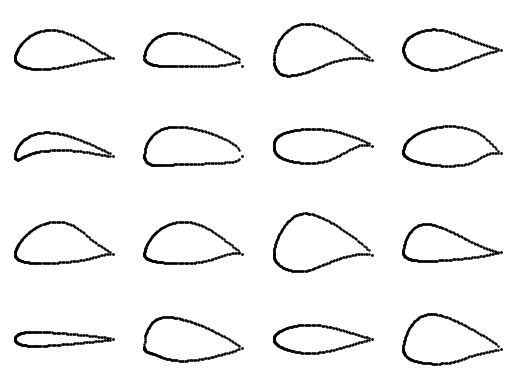


 
 Reconstructed


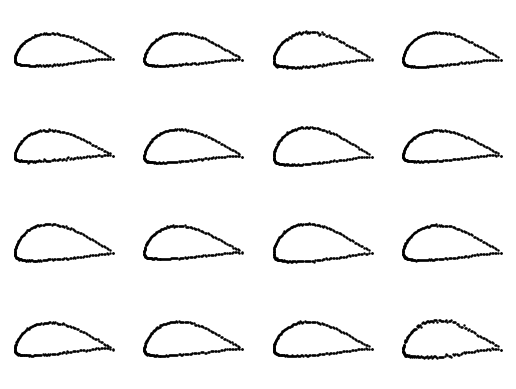


 
 Synthesized airfoils


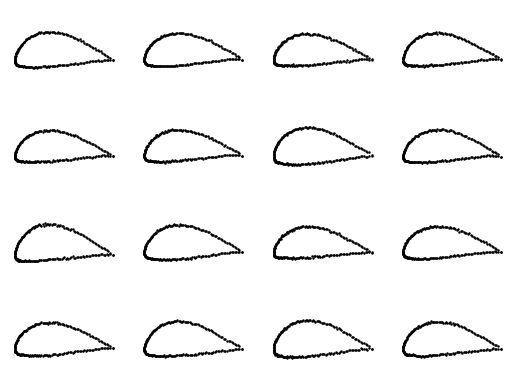

In [5]:
# check if cuda available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# hyperparameters
latent_dim = 16 # please do not change latent dimension
lr = 0.001      # learning rate
num_epochs = 30

# build the model
vae = VAE(airfoil_dim=airfoil_dim, latent_dim=latent_dim).to(device)
print("VAE model:\n", vae)

# define your loss function here
# loss = ?
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    scaled_kl_divergence = kl_divergence
    return recon_loss + scaled_kl_divergence

# define optimizer for discriminator and generator separately
optim = Adam(vae.parameters(), lr=lr)
training_losses = []
epochs = []

# train the VAE model
for epoch in range(num_epochs):
    for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)

        # train VAE
        optim.zero_grad()
        # Forward pass
        recon_x, mu, logvar = vae(y_real)

        # Calculate customized VAE loss
        loss = vae_loss(recon_x, y_real, mu, logvar)

        
        loss.backward()
        optim.step()
        # Store training loss
        training_losses.append(loss.item())
        epochs.append(epoch + (n_batch / len(airfoil_dataloader)))

        # print loss while training
        if (n_batch + 1) % 30 == 0:
            print("Epoch: [{}/{}], Batch: {}, loss: {}".format(
                epoch, num_epochs, n_batch, loss.item()))

# test trained VAE model
num_samples = 100

# reconstuct airfoils
real_airfoils = dataset.get_y()[:num_samples]
recon_airfoils, __, __ = vae(torch.from_numpy(real_airfoils).to(device))
if 'cuda' in device:
    recon_airfoils = recon_airfoils.detach().cpu().numpy()
else:
    recon_airfoils = recon_airfoils.detach().numpy()

# randomly synthesize airfoils
noise = torch.randn((num_samples, latent_dim)).to(device)   # create random noise 
gen_airfoils = vae.decode(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# plot real/reconstructed/synthesized airfoils
print("\n \n Real")
plot_airfoils(airfoil_x, real_airfoils)
print("\n \n Reconstructed")
plot_airfoils(airfoil_x, recon_airfoils)
print("\n \n Synthesized airfoils")
plot_airfoils(airfoil_x, gen_airfoils)

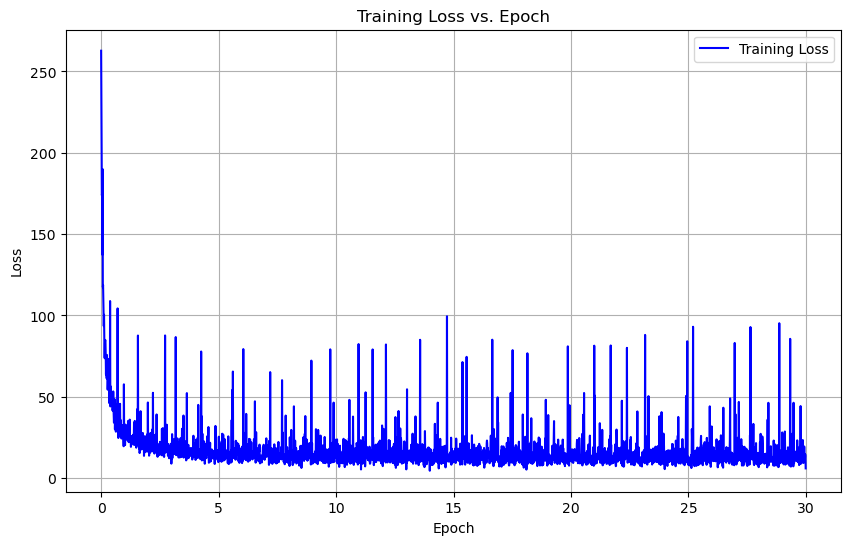

In [6]:
# Plot training loss vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', color='blue')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# GAN

In [56]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, 1)
        # since discriminator is a binary classifier
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.7)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, x):
        # define your feedforward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x
        


class Generator(nn.Module):
    def __init__(self, latent_dim, airfoil_dim):
        super(Generator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, airfoil_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.7)
        self.fc4 = nn.Linear(128, airfoil_dim)
    
    def forward(self, x):
        # define your feedforward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc4(x))
        return x
        

Distrminator model:
 Discriminator(
  (fc1): Linear(in_features=200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
Generator model:
 Generator(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc4): Linear(in_features=128, out_features=200, bias=True)
)
Epoch: [0/30], Batch: 29, Discriminator loss: 1.4334241151809692, Generator loss: 0.4866449236869812
Epoch: [0/30], Batch: 59, Discriminator loss: 1.4237186908721924, Generator loss: 0.49110540747642517
Epoch: [0/30], Batch: 89, Discriminator loss: 1.4289103746414185, Generator loss: 0.490853875875473
Epoch: [1/30], Batch: 29, Discriminator loss: 1.425381064

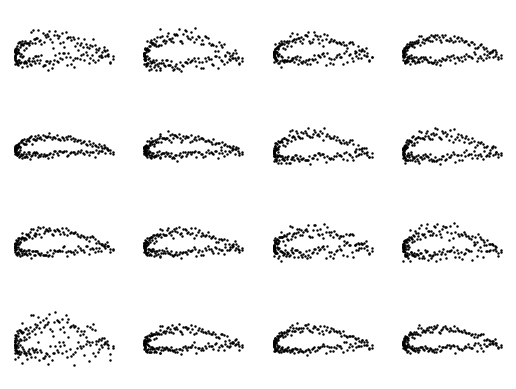

In [57]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# hyperparameters
latent_dim = 16 # please do not change latent dimension
lr_dis = 0.0002 # discriminator learning rate
lr_gen = 0.0002 # generator learning rate
num_epochs = 30

# build the model
dis = Discriminator(input_dim=airfoil_dim).to(device)
gen = Generator(latent_dim=latent_dim, airfoil_dim=airfoil_dim).to(device)
print("Distrminator model:\n", dis)
print("Generator model:\n", gen)

# define your GAN loss function here
# you may need to define your own GAN loss function/class
# loss = ?
def gan_loss(discriminator_output, is_real=True):
    if is_real:
        target = torch.ones_like(discriminator_output)
    else:
        target = torch.zeros_like(discriminator_output)
    return F.binary_cross_entropy_with_logits(discriminator_output, target)

# define optimizer for discriminator and generator separately
optim_dis = Adam(dis.parameters(), lr=lr_dis)
optim_gen = Adam(gen.parameters(), lr=lr_gen)

training_losses_dis = []
training_losses_gen = []
epochs = []

# train the GAN model
for epoch in range(num_epochs):
    for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)

        # train discriminator
        optim_dis.zero_grad()
        # Forward pass for real data
        dis_real_out = dis(y_real)
        loss_dis_real = gan_loss(dis_real_out, is_real=True)
        
        # Generate fake data
        noise = torch.randn((y_real.size(0), latent_dim)).to(device)
        fake_data = gen(noise)
        
        # Forward pass for fake data
        dis_fake_out = dis(fake_data.detach())
        loss_dis_fake = gan_loss(dis_fake_out, is_real=False)
        
        # Total discriminator loss
        loss_dis = loss_dis_real + loss_dis_fake

        
        loss_dis.backward()
        optim_dis.step()

        # train generator
        optim_gen.zero_grad()
        
        noise = torch.randn((y_real.size(0), latent_dim)).to(device)
        fake_data = gen(noise)
        
        # Forward pass for fake data through discriminator
        dis_fake_out = dis(fake_data)
        
        # Generator loss
        loss_gen = gan_loss(dis_fake_out, is_real=True)
        loss_gen.backward()
        optim_gen.step()
        
        # Store training losses
        training_losses_dis.append(loss_dis.item())
        training_losses_gen.append(loss_gen.item())
        epochs.append(epoch + (n_batch / len(airfoil_dataloader)))

        # print loss while training
        if (n_batch + 1) % 30 == 0:
            print("Epoch: [{}/{}], Batch: {}, Discriminator loss: {}, Generator loss: {}".format(
                epoch, num_epochs, n_batch, loss_dis.item(), loss_gen.item()))

# test trained GAN model
num_samples = 100
# create random noise 
noise = torch.randn((num_samples, latent_dim)).to(device)
# generate airfoils
gen_airfoils = gen(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# plot generated airfoils
plot_airfoils(airfoil_x, gen_airfoils)

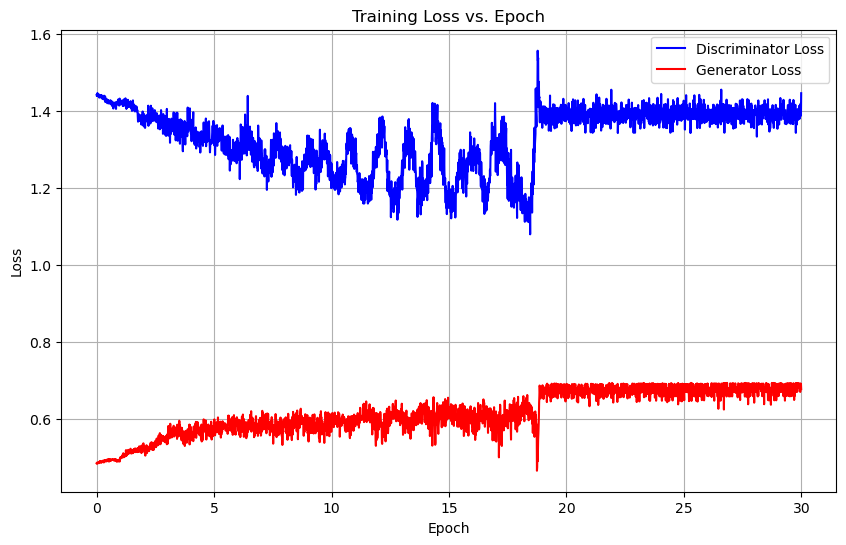

In [58]:
# Plot training loss vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses_dis, label='Discriminator Loss', color='blue')
plt.plot(epochs, training_losses_gen, label='Generator Loss', color='red')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Comparing the synthesized airfoils generated by the Variational Autoencoder (VAE) and the Generative Adversarial Network (GAN)

1. **Visual Quality:**
- The airfoils generated by the VAE may appear more smooth and continuous compared to those generated by the GAN.
- VAEs produces outputs that resemble the input distribution more closely.
- GAN-generated airfoils might exhibit more diversity and variability which has  less smoothness and coherence.

2. **Traning losses:**
- As the GAN is trained to capture the data distribution and produce diverse outputs.
- The GAN seems to have airfoils with relatively consistent quality, as seen by stable Discriminator and Generator losses.
- The synthesized airfoils from the VAE may vary in quality from real.
- The VAE loss shows fluctuations, suggesting some instability or convergence issues.
